<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the data

In [ ]:

import numpy as np
data_array = np.load('/content/drive/MyDrive/GP/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP/GP-Data/group_array.npy')


print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


# Prepare the data for traning

In [ ]:
# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one
label_array = label_array.astype('int')
label_array[label_array==1] = 0
label_array[label_array==2] = 1

In [ ]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

## Split the data into Training ,Testing and Validation

In [ ]:
# Split data_array into train and validate

for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    train_features, train_label = data_array[train_index],label_array[train_index]
    val_features, val_labels = data_array[val_index],label_array[val_index]
    train_groups = group_array[train_index]
    scaler=StandardScaler3D()
    train_features=scaler.fit_transform(train_features)
    val_features=scaler.transform(val_features)
    break



In [ ]:
# Split train_features into train and test
for train_index, test_index in gkf.split(train_features, train_label, groups= train_groups):
    train_features,train_labels=data_array[train_index],label_array[train_index]
    test_features,test_labels=data_array[test_index],label_array[test_index]

    break

In [ ]:
# data spliting percentage
train_p = train_features.shape[0]/data_array.shape[0]
test_p = test_features.shape[0]/data_array.shape[0]
val_p = val_features.shape[0]/data_array.shape[0]

print(f'train_p: {train_p}, test_p: {test_p}, val_p: {val_p}')

print("total: ",train_p + test_p + val_p)

train_p: 0.6612587412587413, test_p: 0.1453146853146853, val_p: 0.19342657342657343
total:  1.0


# CNN-RNN Model

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#resource:https://github.com/dll-ncai/eeg_pre-diagnostic_screening/blob/master/code/chrononet/chrono.py

In [4]:
def block(input):

  """
    Create a block consisting of three parallel convolutional layers followed by concatenation.

    Parameters:
    - input: Input tensor.

    Returns:
    - Concatenated tensor resulting from the parallel convolutional layers.
    """

  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x

In [5]:
# Define the input layer with a shape of (1250, 33)
input = Input(shape=(1250, 33))

# Create the first block
block1 = block(input)

# Create the second block using the 'block' function with the output of the first block as input
block2 = block(block1)

# Create the third block using the 'block' function with the output of the second block as input
block3 = block(block2)

In [6]:
gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)


In [7]:


# Create a Dense layer with 1 unit and sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(gru_out4)

# Define the model with 'input' as the input and 'predictions' as the output
model = Model(inputs=input, outputs=predictions)

# Specify the Adam optimizer with a learning rate of 0.0001
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and accuracy as the evaluation metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1250, 33)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 625, 32)              2144      ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 625, 32)              4256      ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 625, 32)              8480      ['input_1[0][0]']             
                                                                                              

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using training features and labels
hist = model.fit(train_features, train_labels, epochs=50, batch_size=132, validation_data=(val_features, val_labels), callbacks=early_stopping)



Epoch 1/50
36/36 [==============================] - 25s 142ms/step - loss: 0.5959 - accuracy: 0.7301 - val_loss: 0.6344 - val_accuracy: 0.6855
Epoch 2/50
36/36 [==============================] - 2s 66ms/step - loss: 0.5840 - accuracy: 0.7318 - val_loss: 0.6310 - val_accuracy: 0.6855
Epoch 3/50
36/36 [==============================] - 2s 62ms/step - loss: 0.5799 - accuracy: 0.7318 - val_loss: 0.6279 - val_accuracy: 0.6855
Epoch 4/50
36/36 [==============================] - 2s 62ms/step - loss: 0.5745 - accuracy: 0.7318 - val_loss: 0.6175 - val_accuracy: 0.6855
Epoch 5/50
36/36 [==============================] - 2s 62ms/step - loss: 0.5664 - accuracy: 0.7320 - val_loss: 0.6032 - val_accuracy: 0.6862
Epoch 6/50
36/36 [==============================] - 2s 62ms/step - loss: 0.5542 - accuracy: 0.7333 - val_loss: 0.5843 - val_accuracy: 0.6913
Epoch 7/50
36/36 [==============================] - 2s 64ms/step - loss: 0.5318 - accuracy: 0.7390 - val_loss: 0.5769 - val_accuracy: 0.6941
Epoch 8/50


# Evaluate model performance

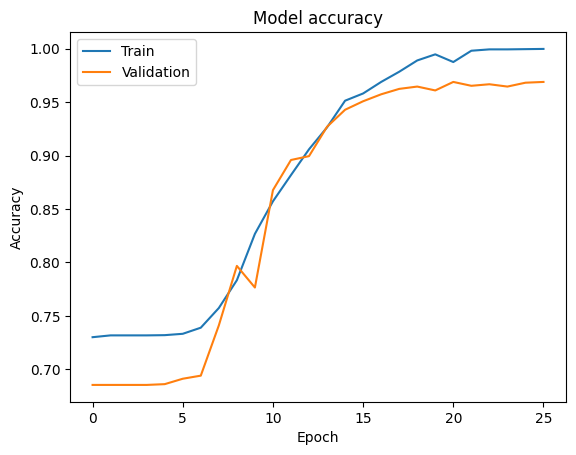

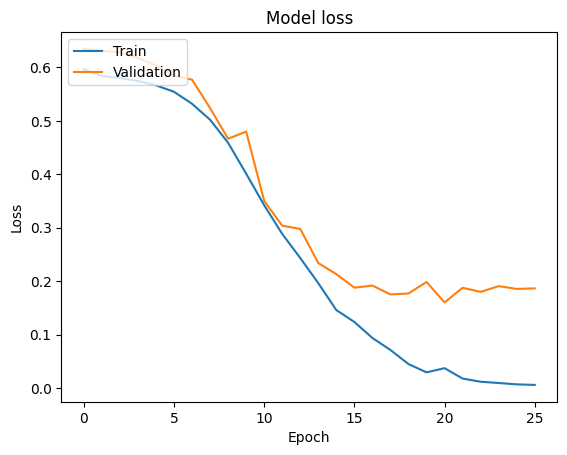

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Average Confusion Matrix:
33/33 [==============================] - 3s 18ms/step


<Figure size 800x600 with 0 Axes>

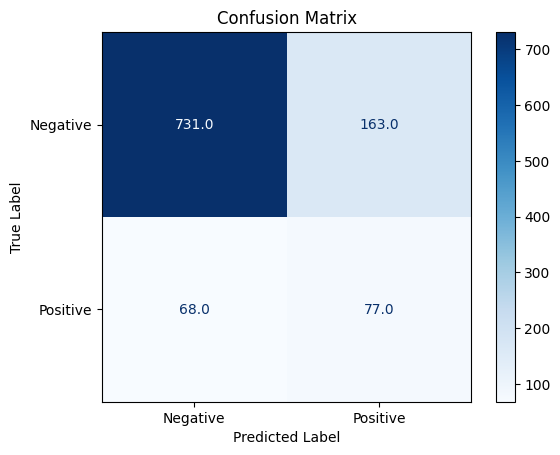

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(test_features)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(test_labels.ravel(), y_pred.ravel())

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       894
           1       0.32      0.53      0.40       145

    accuracy                           0.78      1039
   macro avg       0.62      0.67      0.63      1039
weighted avg       0.83      0.78      0.80      1039



In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix


# Extract values from confusion matrix
true_positives = cm[1, 1]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]

# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.3208
Recall: 0.5310
F1 Score: 0.4000
